# GA DSI Capstone: 
# Predicting Myers-Briggs Personality Types from Social Media Posts

### Name: Maria Yarolin

### Due Date: December 18, 2017

---

## Executive Summary

**Problem Statement**

*Personality* refers to individual differences in characteristic patterns of thinking, feeling and behaving. *Personality typologies* classify different types of individuals to reveal and enhance the understanding of their behaviors.

The Myers-Briggs Type Indicator (MBTI) is a psychological assessment tool to classify people into one of 16 different personality types. The classification system consists of a four-letter code based on four axes, where each letter in the code refers to the predominant trait in each axis. The four axes are:
- Introversion (I) – Extroversion (E)
- Intuition (N) – Sensing (S)
- Thinking (T) – Feeling (F)
- Judging (J) – Perceiving (P)

For example, a person scoring higher on Introversion, Sensing, Thinking, and Judging would be classified with an ISTJ personality type.

This capstone project uses natural language processing techniques to analyze text postings on a social forum, and predict the writers' personality type using a classification model. It also compares personality types based on other factors such as the length, polarity, and subjectivity of these posts.


**Data source**

The dataset was obtained on Kaggle (https://www.kaggle.com/datasnaek/mbti-type), and contains data from 8,675 subjects. 

The original dataset consists of 2 columns: 
- *type*: subjects’ known MBTI code (16 codes in total)
- *posts*: subjects’ 50 most recent posts on PersonalityCafe, an online forum focusing on personality types (http://personalitycafe.com/forum/). The site is geared toward the general public (not psychology professionals) with an interest in the topic of personality types

The dataset is skewed toward subjects from the Introverted-Intuitive personality types (INFJ, INFP, INTJ, and INTP).
Also, personality types are self-reported by the users of this forum, and it is assumed that they are reported accurately. 

**Key findings**

Three different classification models were tested: K-Neighbors Classifier, Random Forest Classifier, and One-Vs-The-Rest Classifier. The One-Vs-The-Rest Classifier, although having only the second-highest accuracy score of the three (0.265), cleared the 0.211 baseline and also predicted classes across the entire 16-class range -- unlike the top-scoring Random Forest Classifier. 

On average, subjects used 26.4 words per post, with a neutral polarity (0.125) and moderate subjectivity (0.535).

---

## Document Sections
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis)
    - [Data dictionary](#data-dictionary)
- [Preprocessing](#preprocessing)
- [Classification](#classification)
    - [Model: Random Forest Classifier](#random-forest-classifier)
    - [Model: KNeighbors Classifier](#k-neighbors-classifier)
    - [Model: OneVsRest Classifier](#one-vs-rest-classifier)
- [Sentiment Analysis and Word Count](#text-analysis)
    - [Length of Post](#length-of-post)
    - [Polarity](#polarity)
    - [Subjectivity](#subjectivity)
- [Conclusion](#conclusion)
- [Next Steps](#next-steps) 

---

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis (EDA)

In [1]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from textblob import TextBlob

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [2]:
# Load dataset
df = pd.read_csv('/Users/mariayarolin/GA/Projects/Capstone/capstone/Datasets/mbti_1.csv')

<a id='data-dictionary'></a>
**Data Dictionary** 

Variables in original dataframe:
- *type*: (string) four-letter Myers-Briggs Type Index (MBTI) code
- *posts*: (string) text of fifty most recent posts to the *PersonalityCafe* forum

New variables added for analysis in the *df_working* datafile:
- *I-E*: (string) code on Introversion-Extroversion axis, derived from *type*
- *N-S*: (string) code on Intuition-Sensing axis, derived from *type*
- *T-F*: (string) code on Thinking-Feeling axis, derived from *type*
- *J-P*: (string) code on Judging-Perceiving axis, derived from *type*
- *posts_r*: (string) cleaned post text, derived from *posts*
- *total_words*: (integer) number of total words across 50 posts, derived from *posts*
- *avg_words_per_post*: (float) average number of words per post, derived from *posts* and *total words*
- *polarity*: (float) polarity score (range -1 to 1)
- *subjectivity*: (float) subjectivity score (range 0 to 1)

In [19]:
# View first five rows of dataset
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# View full text of the first post
print(df.iloc[0,1])

'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|

Examining the raw text, it is noted that: 
- Each post is separated by 3 pipes ( ||| ). 
- Website links appear frequently in this post. 
- The 4-letter personality type codes are referenced frequently. These posts were obtained from a forum specifically dedicated to personality types, so the subjects were primed regarding their classification. The data transformation should add the codes for the 16 types to the list of stopwords, to avoid biasing the model. 

In [5]:
# View shape of dataset
df.shape

(8675, 2)

There are 8675 rows and 2 columns in the dataframe.

In [6]:
# View information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
type     8675 non-null object
posts    8675 non-null object
dtypes: object(2)
memory usage: 135.6+ KB


The column names are 'type' and 'posts'. Both are datatype 'object'. There are no null values.

In [7]:
# Examine number of unique items are in the 'type' (classification) column
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'], dtype=object)

The 'type' column contains 16 unique codes, representing the 16 different personality types.

In [8]:
# Explore the counts for each of these types
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Observation: Of the 8675 records, INFP is the most frequently-appearing Myers-Briggs type in this dataset (n=1832), while ESTJ is the least frequent (n=39).

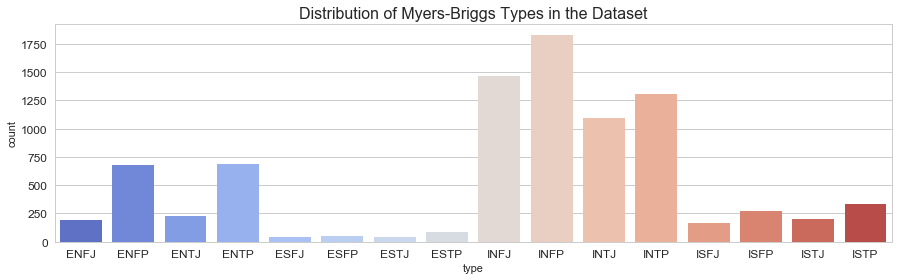

In [16]:
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that INFP (Introversion - Intuition - Feeling - Perceiving) is the most frequently appearing type in the dataset, followed by INFJ (Introversion - Intuition - Feeling - Judging). Overall, the dataset contains many more Intuitive-Intuition (IN-) groupings than any other type. Conversely, the dataset contains very few Extroversion-Sensing (ES-) types.

It is possible that the sample is highly self-selected, and people who display Introverted-Intuitive traits are more inclined to be interested in personality theory and/or users of the PersonalityCafe site.

In [21]:
# Explore the counts for each axis of the types
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    6676
E    1999
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    7478
S    1197
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    4694
T    3981
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    5241
J    3434
Name: type, dtype: int64 



Viewed by individual axes, we again see the dataset contains many more Introverts (I) than Extroverts (E), and more Intuitives (N) than Sensers (S). The distributions of Thinkers (T) vs. Feelers (F), and Judgers (J) vs. Perceivers (P) are more balanced.

---

<a id='preprocessing'></a>
## Preprocessing

In [3]:
# Create a working copy of the dataframe
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# Create a binary column for each of the 4 axis types for later analysis
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging


Codes for the new columns:
- I-E: Introversion - Extroversion
- N-S: Intuition - Sensing
- T-F: Thinking - Feeling
- J-P: Judging - Perceiving

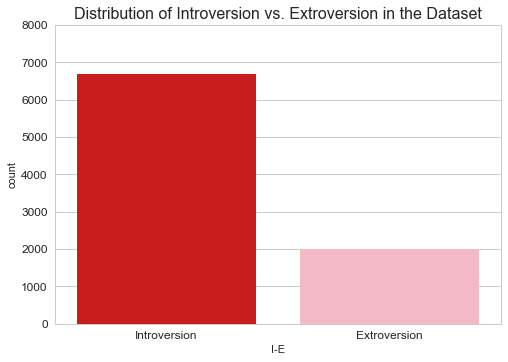

In [24]:
# Countplot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above show that the dataset is heavily skewed toward Introversion over Extroversion.

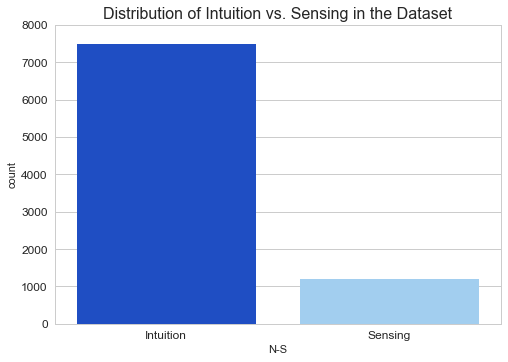

In [25]:
# Countplot of Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is heavily skewed toward Intuition over Sensing.

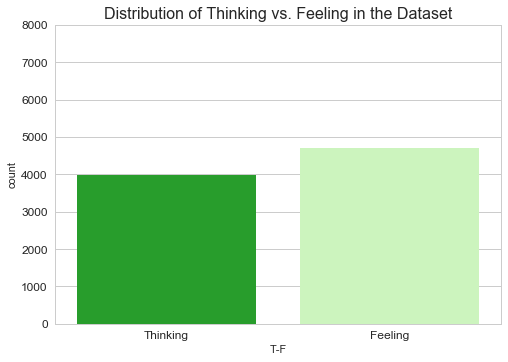

In [26]:
# Countplot of Thinking - Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is somewhat skewed toward Feeling over Thinking.

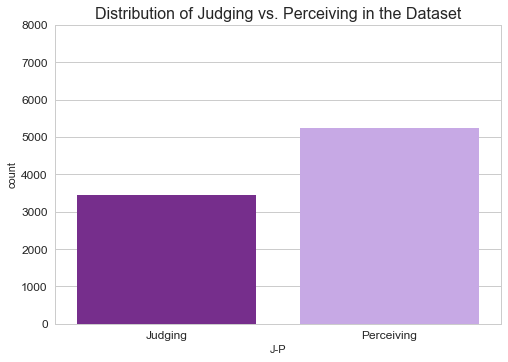

In [27]:
# Countplot of Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is moderately skewed toward Perceiving over Judging.

In [28]:
# Subset the posts column for further exploration
posts = df_working['posts'].copy()
posts = posts.apply(lambda x: x.replace('|||', ' ')) # replaces post separators with empty space
posts.head()

0    'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired. That's another silly misconcept...
Name: posts, dtype: object

**CountVectorizer**

*CountVectorizer* encodes text by splitting a set of words into one column per word, with (by default) the count of the word for that row in that column.

In [13]:
# Run an initial CountVectorizer with default settings on the posts column to see what's there
cv = CountVectorizer()
cv.fit_transform(posts)

<8675x145412 sparse matrix of type '<class 'numpy.int64'>'
	with 4516646 stored elements in Compressed Sparse Row format>

In [14]:
# Convert the output of the transformation to a dense matrix
cv.transform(posts).todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [15]:
# Convert to a dataframe to get feature names and see the distribution of words
df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())
df_posts.head()

,00,000,0000,000000,0000000000,000000000000000,00000000000000000000000000000000027,00000011,000000111,0000001111,...,ｓｏ,ｔｒｕｍｐu3000ｉｓu3000ａｎu3000ｅｓｔｐ,ｖａｐｏｒｗａｖｅ,ｗｈｙu3000ｉｓu3000ａｎｙｏｎｅu3000ｓｔｉｌｌu3000ｄｉｓｃｕｓｓｉｎｇu3000ｔｈｉｓ,ﾉωﾉ,ﾉｼ,ﾉﾞ,ﾉﾟ,ﾟдﾟщ,ﾟﾟ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Examine shape after creation of columns
df_posts.shape

(8675, 145412)

CountVectorizer created 145,412 columns from the single *posts* column.

In [17]:
# Examine the top 10 occurring words
print(df_posts.sum().sort_values(ascending=False).head(10))

the     309589
to      305454
and     244200
you     187937
it      186462
of      185941
that    163696
is      140673
in      131749
my      126883
dtype: int64


Initial observations on the data in the *posts* column, after the first CountVectorizer pass:

The top 10 words are common and non-subject-specific words which appear in the stopwords list. There are also 
145,412 columns. We need to rerun CountVectorizer and add some arguments to whittle down the list.

#### Add Words to the Stopwords List

*stopwords* eliminates common words that add no information to the text content, or can bias a model.

Since the posts were obtained from a site specifically geared toward the topic of personality type, it is possible that the subjects have been primed to behave in a way that conforms to the characteristics of their defined personality type. It is noted that some subjects reference their (or others') personality type code within some of the posts. Thus, these codes are excluded to avoid biasing the model (e.g. specific references to the 4-letter code).

In [7]:
# Add to the stopwords list each of the 16 codes
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
stop = stopwords.words('english')

for type in types:
    stop.append(type)

stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [19]:
# Rerun CountVectorizer to exclude stopwords, allow 2-word pairs, and limit the number of columns to 1000
cv = CountVectorizer(stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(posts)
cv.transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), 
             columns=cv.get_feature_names())
df_posts.head()

,10,100,12,15,20,30,50,ability,able,absolutely,...,years ago,yep,yes,yesterday,yet,young,younger,youtu,youtube,youtube com
0,0,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,16,16
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,1,0,2,1,2,...,0,0,1,0,0,0,0,0,3,3
3,0,0,0,0,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,2,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,2,1,1


In [20]:
df_posts.shape

(8675, 1000)

In [21]:
# Examine the top 10 occuring words in this round of CountVectorizer
print(df_posts.sum().sort_values(ascending=False).head(10))

like      69706
think     49847
people    47908
one       37232
know      36950
really    35305
would     35035
get       30822
time      27628
com       25869
dtype: int64


In [8]:
# Define a preprocessor function to clean the text by grouping into stems, removing separators, 
# replacing hyperlinks, removing punctuation, removing digits, and convert letters to lower case

def cleaner(text):
    stemmer = PorterStemmer()                                        # groups words having the same stems
    text = text.replace('|||', ' ')                                  # replaces post separators with empty space
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)  # replace hyperlink with 'URL'
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))      # removes digits
    text = text.lower().strip()                                      # convert to lower case
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [31]:
# View original text to confirm the cleaner is working properly
df.posts.iloc[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [32]:
# view cleaned text
cleaner(df.posts.iloc[0])

'url url moment url sportscent top ten play url prank lifechang experi life url url repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac url hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth url url welcom stuff url game set match prozac wellbrutin least thirti minut move leg dont mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item youv determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game cool url appear late sad there someon everyon wait thought confid good thing cherish time solitud bc revel within inner world wherea time id workin enjoy time dont worri peopl alway around yo ladi your complimentari personalitywel hey main social outlet xbox live conver

Viewing the cleaned text confirms that text was grouped into stems, ||| separators removed, hyperlinks replaced, punctuation removed, digits removed, and letters converted to lower case

In [26]:
cv.vocabulary_

{'http': 397,
 'www': 983,
 'youtube': 998,
 'com': 130,
 'watch': 936,
 'media': 539,
 'tumblr': 899,
 'jpg': 445,
 'https': 399,
 'top': 885,
 'life': 481,
 'experience': 255,
 'today': 880,
 'may': 532,
 'perc': 634,
 'last': 463,
 'thing': 862,
 'friend': 308,
 'posted': 663,
 'facebook': 264,
 'next': 582,
 'day': 173,
 'rest': 717,
 'hello': 374,
 'sorry': 794,
 'hear': 370,
 'natural': 570,
 'relationship': 707,
 'time': 876,
 'every': 244,
 'moment': 554,
 'try': 897,
 'figure': 288,
 'hard': 366,
 'times': 877,
 'friendship': 310,
 'girl': 331,
 'content': 149,
 'home': 388,
 'welcome': 946,
 'stuff': 827,
 'red': 704,
 'game': 320,
 'set': 752,
 'least': 474,
 'minutes': 551,
 'moving': 565,
 'mean': 535,
 'maybe': 533,
 'basically': 70,
 'come': 132,
 'three': 874,
 'type': 903,
 'types': 905,
 'want': 932,
 'would': 974,
 'likely': 485,
 'use': 916,
 'given': 335,
 'cognitive': 126,
 'functions': 317,
 'left': 476,
 'things': 863,
 'indeed': 419,
 'video': 924,
 'good': 345

In [28]:
# Run a final CountVectorizer on posts to include the cleaning preprocessor arguments
cv = CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), 
             columns=cv.get_feature_names())
df_posts.head()

,abil,abl,absolut,accept,account,accur,across,act,action,activ,...,year old,yep,yesterday,yet,youd,youll,young,younger,youtub,youv
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,1,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [29]:
# Confirm shape
df_posts.shape

(8675, 1000)

The transformed dataset contains 8675 rows and 1000 columns, as expected.

In [30]:
# Examine the top 10 occuring words in this round of CountVectorizer
print(df_posts.sum().sort_values(ascending=False).head(10))

im        79995
like      75765
think     58275
dont      52778
peopl     47904
one       39656
know      39430
get       38870
feel      37014
realli    35223
dtype: int64


In [31]:
# View the tokens created
with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    print(df_posts)

    abil  abl  absolut  accept  account  accur  across  act  action  activ  \
0      0    0        0       0        0      0       0    0       0      0   
..   ...  ...      ...     ...      ...    ...     ...  ...     ...    ...   

    actual  add  admit  advic  affect  afraid  age  ago  agre  ah  allow  \
0        0    0      0      0       0       0    1    1     0   0      0   
..     ...  ...    ...    ...     ...     ...  ...  ...   ...  ..    ...   

    almost  alon  along  alreadi  also  although  alway  amaz  amount  angri  \
0        0     0      0        0     0         0      1     0       0      0   
..     ...   ...    ...      ...   ...       ...    ...   ...     ...    ...   

    anim  annoy  anoth  answer  answer question  anxieti  anymor  anyon  \
0      0      0      0       0                0        0       0      0   
..   ...    ...    ...     ...              ...      ...     ...    ...   

    anyon els  anyth  anyway  apart  apolog  appar  appear  appli  ap

It is confirmed that the web links have been converted to the term 'url', and the 16 personality types are excluded 
as tokens (to avoid biasing the model).

---

<a id='classification'></a>
## Classification

##### Baseline calculation

In [33]:
# Determine baseline
baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
baseline

0.21118155619596543

The baseline is 0.211 (INFP is the largest class with 1832 of the 8675 cases).

##### Train-test split

In [60]:
# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(df['posts'].values,
                                                   df['type'].values,
                                                   test_size=0.30, random_state=42)
print('X_train ', X_train.shape, '\n', 'X_test ', X_test.shape, '\n', 'y_train ', y_train.shape, '\n', 
      'y_test', y_test.shape)

X_train  (6072,) 
 X_test  (2603,) 
 y_train  (6072,) 
 y_test (2603,)


There are 6072 cases in the training set, and 2603 cases in the testing set.

In [38]:
# Run CountVectorizer on the X train/test ('posts' column) using the arguments identified earlier
cv = CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

##### Truncated SVD

*TruncatedSVD* is a variant of principal component analysis (pca) used on sparse matrices to reduce dimensionality

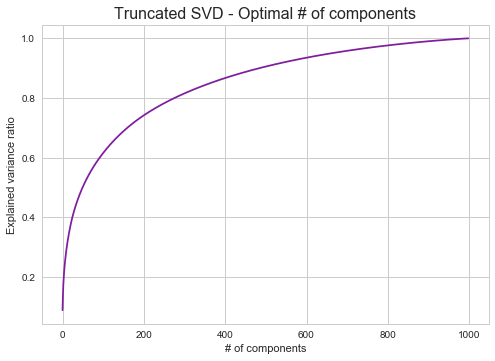

In [40]:
# Run Truncated SVD
# First use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

The graph above suggests that approximately 175 components would be most effective, since it is where the graph begins to flatten out.

In [41]:
# Run a Truncated SVD with 175 components
tsvd = TruncatedSVD(n_components=175)
tsvd.fit(X_train_cv)
X_train_tsvd = tsvd.transform(X_train_cv)

X_test_cv = cv.transform(X_test)
X_test_tsvd = tsvd.transform(X_test_cv)

**Preprocessing Pipeline**

In [61]:
# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
    CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=175))

X_train_tsvd = pipeline_preprocessing.fit_transform(X_train)
X_test_tsvd = pipeline_preprocessing.transform(X_test)

**A brief guide to interpreting the Classification Report:**
- Precision = True Positives / (True Positives + False Positives)
    - A precision score of 1 indicates that the classifier never mistakenly added observations from another class. A precision score of 0 would mean that the classifier misclassified every instance of the current class.
- Recall = True Positives / (True Positives + False Negatives)
    - A recall score of 1 indicates that the classifier correctly predicted (found) all observations of the current class (by implication, no false negatives, or misclassifications of the current class). A recall score of 0 alternatively means that the classifier missed all observations of the current class.
- F1-Score = 2 x (Precision x Recall) / (Precision + Recall)
    - The f1-score's best value is 1 and worst value is 0, like the precision and recall scores. It is a useful metric for taking into account both measures at once.
- Support is simply the number of observations of the labelled class.

<a id='modeling'></a>
### Modeling

<a id='random-forest-classifier'></a>
#### Model: Random Forest Classifier

*RandomForestClassifier* is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [54]:
# Fit and score a Random Forest Classifier
# Parameters: 30 estimators, min 50 samples per leaf node, out-of-bag samples to estimate generalization accuracy
rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
rfc.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", rfc.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, rfc.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", rfc.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, rfc.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  0.413372859025
Confusion Matrix:
[[   0    0    0    0    0    0    0    0   26   97    4    7    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   68  363    8   40    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   26   72   21   54    0    0
     0    0]
 [   0    0    0    5    0    0    0    0   54  231   36  158    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    7   21    1    3    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    3   21    2   13    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    4   12    1    5    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   10   32    4   18    0    0
     0    0]
 [   0    0    0    0    0    0    0    0  513  441   13   69    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   20 1195   14   37    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   92  295  266  127    0    0
     0    0]
 [   0  

/Users/mariayarolin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy:  0.269688820592
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   8  41   3   4   0   0   0   0]
 [  0   0   0   0   0   0   0   0  27 149   9  11   0   0   0   0]
 [  0   0   0   0   0   0   0   0   7  27   4  20   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  99  17  55   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   7   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   5   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   9   3   3   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3  13   1   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0  71 308  12  43   0   0   0   0]
 [  0   0   0   0   0   0   0   0  53 457  11  45   0   0   0   0]
 [  0   0   0   0   0   0   0   0  51 147  32  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0  47 192  23 142   0   0   0   0]
 [  0   0   0   0   0   0   0   0  11  39   5   6   0   0   0   0]
 [  0   0   0   0   0   0   0   0  10  67   2   5   0   0   0   0]
 [  0   0   0   0 

With the default arguments in the Random Forest Classifier model, the Accuracy on the training set was 0.993 and the testing set was 0.194, compared to the baseline of 0.211. The high accuracy of the training data but low accuracy of predictions on the test set suggests the model was overfit.

Using n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1 gives a training Accuracy of 0.413 and 
testing Accuracy of 0.270. This is a more realistic score for the training set (suggesting the model is not overfit)
and an improved score on predicting the testing set. However, each of the predictions falls within a limited 
subset of only four of the sixteen classes.

In [55]:
# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_rfc = np.array(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))

cm_randomforest = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_randomforest

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,0,0,0,0,0,0,0,8,41,3,4,0,0,0,0
ENFP,0,0,0,0,0,0,0,0,27,149,9,11,0,0,0,0
ENTJ,0,0,0,0,0,0,0,0,7,27,4,20,0,0,0,0
ENTP,0,0,0,0,0,0,0,0,30,99,17,55,0,0,0,0
ESFJ,0,0,0,0,0,0,0,0,3,7,0,0,0,0,0,0
ESFP,0,0,0,0,0,0,0,0,2,5,0,2,0,0,0,0
ESTJ,0,0,0,0,0,0,0,0,2,9,3,3,0,0,0,0
ESTP,0,0,0,0,0,0,0,0,3,13,1,8,0,0,0,0
INFJ,0,0,0,0,0,0,0,0,71,308,12,43,0,0,0,0
INFP,0,0,0,0,0,0,0,0,53,457,11,45,0,0,0,0


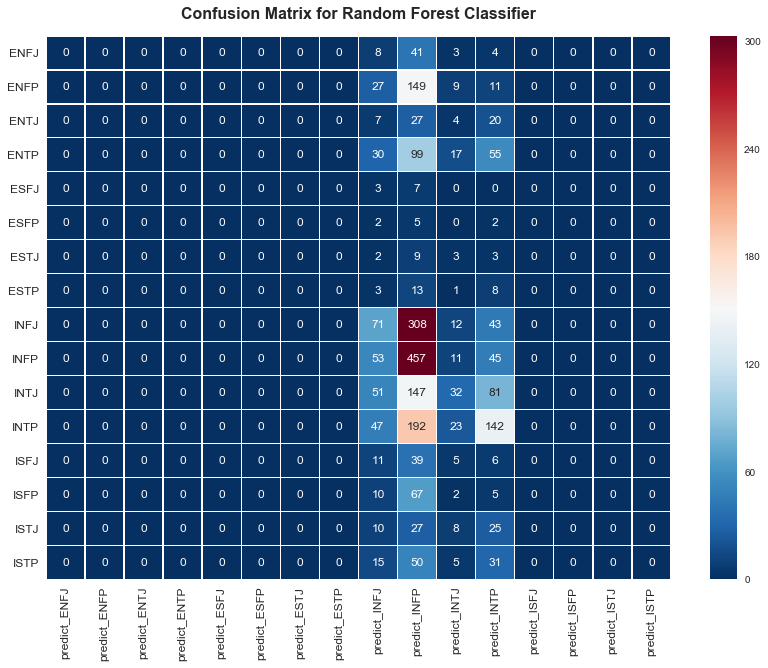

In [56]:
# Create confusion matrix heatmap of Random Forest Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm_randomforest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In the heatmapped confusion matrix above, it is clear that the Random Forest Classifier model is making predictions only within four of the sixteen classes:
INFJ, INFP, INTJ, and INTP, which are the most abundant classes in the dataset. The other twelve categories receive 
no predictions from this model at all. Despite having an accuracy score higher than the baseline, this model is not suited to predicting classes outside of the ones with the highest frequency.

<a id='k-neighbors-classifier'></a>
#### Model: KNeighborsClassifier

*KNeighborsClassifier* is a nonparametric classification model that finds the observations in its training data that are "nearest" to the observation to predict; it then averages or takes a vote of those training observations' target values to estimate the value for the new data point.

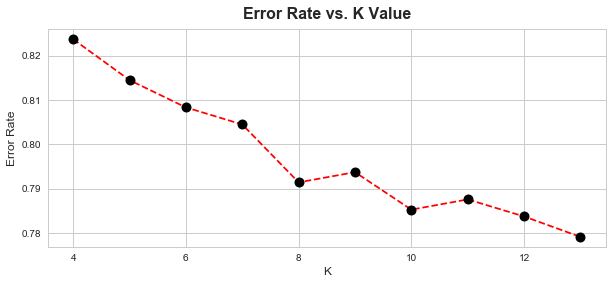

In [64]:
# Search for the optimal number of neighbors to use
error_rate = []

for i in range(4,14):
    knn_lc = KNeighborsClassifier(n_neighbors=i)
    knn_lc.fit(X_train_tsvd, y_train)
    
    pred_i = knn_lc.predict(X_test_tsvd)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10, 4))
plt.plot(range(4,14), error_rate, color='red', linestyle='dashed',
         marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value', fontsize=16,
          fontweight='bold', y=1.02)
plt.xlabel('K', fontsize=12, y=1.02)
plt.ylabel('Error Rate', fontsize=12, x=1.02);

According to the graph, 13 is the optimal number of neighbors to use in the KNeighborsClassifier model. It gives a
relatively low error rate for the lowest k neighbors (more neighbors give diminishing returns). But this should be
confirmed with a grid search to find the best hyperparameters.

In [66]:
# Grid Search to find the best parameters on KNeighbors Classifier
k_dict = {
    'n_neighbors': [7,9,11,13,15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],}
        # p = power parameter for the Minkowski metric. 
        # 1 is Manhattan; 2 is Euclidean

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, k_dict, verbose=2, n_jobs=-1)
# if n_jobs = -1, then the number of jobs is set to the number of CPU cores.
gs.fit(X_train_tsvd, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_neighbors=7, p=1, weights=uniform .............................
[CV] n_neighbors=7, p=1, weights=uniform .............................
[CV] n_neighbors=7, p=1, weights=uniform .............................
[CV] n_neighbors=7, p=1, weights=distance ............................
[CV] .............. n_neighbors=7, p=1, weights=uniform, total=   5.6s
[CV] n_neighbors=7, p=1, weights=distance ............................
[CV] .............. n_neighbors=7, p=1, weights=uniform, total=   5.6s
[CV] .............. n_neighbors=7, p=1, weights=uniform, total=   5.6s
[CV] n_neighbors=7, p=1, weights=distance ............................
[CV] ............. n_neighbors=7, p=1, weights=distance, total=   5.6s
[CV] n_neighbors=7, p=2, weights=uniform .............................
[CV] n_neighbors=7, p=2, weights=uniform .............................
[CV] ............. n_neighbors=7, p=1, weights=distance, total=   5.5s
[CV] n_neighbors

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min


[CV] ............ n_neighbors=11, p=2, weights=distance, total=   5.5s
[CV] n_neighbors=13, p=1, weights=uniform ............................
[CV] ............ n_neighbors=11, p=2, weights=distance, total=   5.5s
[CV] ............ n_neighbors=11, p=2, weights=distance, total=   5.5s
[CV] n_neighbors=13, p=1, weights=uniform ............................
[CV] n_neighbors=13, p=1, weights=distance ...........................
[CV] ............. n_neighbors=13, p=1, weights=uniform, total=   5.5s
[CV] n_neighbors=13, p=1, weights=distance ...........................
[CV] ............. n_neighbors=13, p=1, weights=uniform, total=   5.4s
[CV] n_neighbors=13, p=1, weights=distance ...........................
[CV] ............. n_neighbors=13, p=1, weights=uniform, total=   5.5s
[CV] n_neighbors=13, p=2, weights=uniform ............................
[CV] ............ n_neighbors=13, p=1, weights=distance, total=   5.5s
[CV] n_neighbors=13, p=2, weights=uniform ............................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [67]:
print('Best score: ', gs.best_score_)
print('Best parameters: ', gs.best_params_)

Best score:  0.227108036891
Best parameters:  {'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


The grid search suggests that the optimal number of neighbors is 13. The optimal weight function is 'distance,' 
where points are weighted by the inverse of their distance (closer neighbors of a query point will have a greater 
influence than neighbors which are further away). These hyperparameters will be used in the KNeighborsClassifier 
model. 
The optimal power parameter (p) for the Minkowski metric is 2, indicating Euclidean distance. This is the default
parameter for this model so no adjustments are needed on that hyperparameter.

In [82]:
# Fit and score a KNeighborsClassifier using 13 neighbors and distance weighting function
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", knn.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, knn.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, knn.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", knn.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, knn.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  1.0
Confusion Matrix:
[[ 134    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  479    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  173    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  484    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   32    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0   39    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   22    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0   64    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0 1036    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0 1266    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0  780    0    0    0
     0    0]
 [   0    0    0   

/Users/mariayarolin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Using the hyperparameters suggested by the grid search (13 neighbors, distance weighting function, and Euclidean distance), the prediction accuracy of the model on the training set is 1.0 which suggests an overfit model. The accuracy on the test set is 0.217, just over the baseline of 0.211. The accuracy is lower than that of the RandomForestClassifier model, but the predictions are not limited to just the Introversion-Intuition subset of 
classes.

In [70]:
# Convert confusion matrix for KNeightbors Classifier model to a dataframe to prepare it for heatmapping
cm_knn = np.array(confusion_matrix(y_test, knn.predict(X_test_tsvd)))

cm_kneighbors = pd.DataFrame(cm_knn, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_kneighbors

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,3,0,2,0,0,0,0,13,24,4,10,0,0,0,0
ENFP,1,13,0,10,0,0,0,1,43,84,13,31,0,0,0,0
ENTJ,0,0,0,10,0,0,0,0,10,13,9,16,0,0,0,0
ENTP,0,2,2,26,0,0,0,0,30,54,38,47,0,1,0,1
ESFJ,0,0,0,0,0,0,0,0,4,4,1,1,0,0,0,0
ESFP,0,1,0,0,0,0,0,0,1,4,1,2,0,0,0,0
ESTJ,0,1,1,0,0,0,0,0,2,2,5,6,0,0,0,0
ESTP,0,1,0,3,0,0,0,0,6,8,5,2,0,0,0,0
INFJ,2,18,0,19,0,1,0,0,88,179,47,75,0,1,0,4
INFP,0,27,1,24,0,0,0,0,108,252,51,91,3,3,0,6


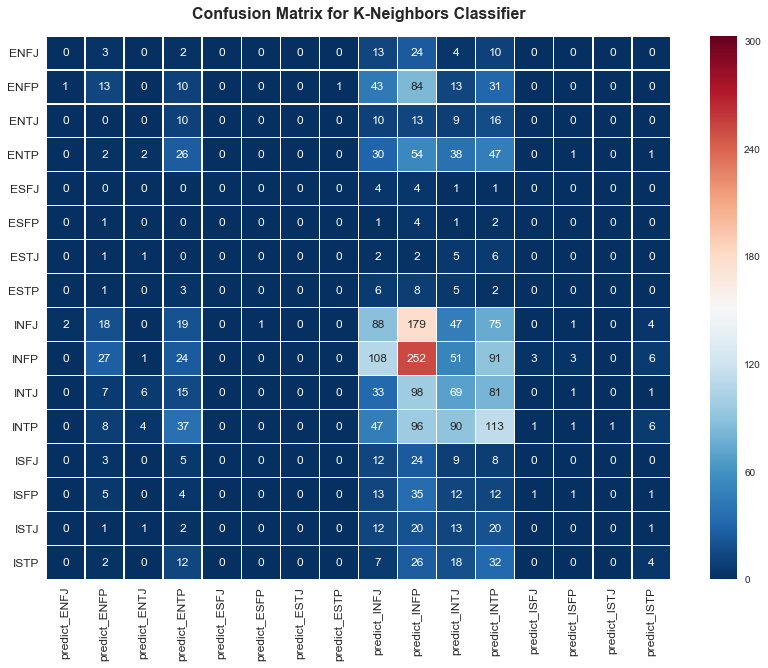

In [79]:
# Create confusion matrix heatmap of KNeighbors Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for K-Neighbors Classifier',
          fontweight='bold', y=1.02, fontsize=16)
sns.heatmap(cm_kneighbors, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

As shown in the heatmapped confusion matrix above, the KNeighbors Classifier is best at predicting cases in the Introversion/Intuition (IN-) classes, which are the most abundant of this dataset. However, unlike the RandomForest Classifier, this model makes predictions outside of those four groups as well. There is still much misclassification, yet it is notable that many of these incorrect labelings are correct on three of the four axes - e.g. ENFP subjects labeled as INFP (where their Intuitive, Feeling, and Perceiving status is guessed accurately, but they are Extroverts misattributed as Introverts).

<a id='one-vs-rest-classifier'></a>
#### Model: OneVsRestClassifier

*OneVsRestClassifier* is a multiclass classifier in which a class is fitted against all the other classes; since each class is represented by one and only one classifier, it is possible to gain knowledge about the class by inspecting its corresponding classifier.

In [11]:
# Fit and score a One-Vs-The-Rest Classifier
ovrc = OneVsRestClassifier(LinearSVC(random_state=123))
ovrc.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", ovrc.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, ovrc.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, ovrc.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", ovrc.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ovrc.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, ovrc.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  0.308959156785
Confusion Matrix:
[[  0   1   0   7   0   0   0   0  53  70   3   0   0   0   0   0]
 [  0   7   0  54   0   0   0   1 116 290  10   0   0   0   0   1]
 [  0   1  15  41   0   0   0   1  30  58  24   3   0   0   0   0]
 [  0   3   4 195   3   2   0   1  65 187  16   7   0   0   0   1]
 [  0   0   0   1  18   0   0   0   6   7   0   0   0   0   0   0]
 [  0   0   0   7   0   4   0   0   3  23   2   0   0   0   0   0]
 [  0   0   0   0   0   0  21   0   0   1   0   0   0   0   0   0]
 [  0   1   0  14   0   0   0  12  12  21   4   0   0   0   0   0]
 [  0   1   1  58   1   1   0   3 407 531  22   5   1   3   0   2]
 [  0   2   1  68   1   1   0   0 212 949  26   4   1   1   0   0]
 [  0   1  14 120   1   1   0   0 146 301 166  24   2   0   0   4]
 [  0   2   1 199   0   0   0   3 128 412  89  61   0   1   0   4]
 [  0   1   0  13   0   0   0   1  27  59   2   0   1   1   0   0]
 [  0   0   0  13   0   0   0   0  36 128   8   0   0   1   0   1]
 [  0

/Users/mariayarolin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using a OneVsRestClassifier model with LinearSVC as the estimator object, the accuracy predicting the training set
is 0.309, and predicting on the training set the accuracy is 0.265 which is higher than the 0.211 baseline. And 
while many of the predictions occur in the Introversion-Intuitive classes as in the other models, it is not limited 
to these classes as in the Random Forest model. There are predictions in the Extroversion classes and the other 
Introversion classes as well.

In [12]:
# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_ovrc = np.array(confusion_matrix(y_test, ovrc.predict(X_test_tsvd)))

cm_onevsrest = pd.DataFrame(cm_ovrc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_onevsrest

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,0,1,0,1,0,0,0,18,33,2,0,0,1,0,0
ENFP,0,2,1,21,2,1,0,3,47,116,3,0,0,0,0,0
ENTJ,0,0,1,14,2,0,2,0,15,16,4,3,0,0,0,1
ENTP,0,2,3,62,1,0,3,1,35,80,8,5,0,0,0,1
ESFJ,0,0,0,1,0,0,0,0,5,4,0,0,0,0,0,0
ESFP,0,0,0,3,0,0,0,0,2,4,0,0,0,0,0,0
ESTJ,0,1,2,2,1,0,0,0,4,5,1,0,0,0,0,1
ESTP,0,0,0,6,1,0,0,1,3,12,0,0,0,1,0,1
INFJ,0,0,0,29,3,1,1,3,147,234,12,1,0,1,0,2
INFP,0,0,0,33,8,0,2,0,102,408,10,2,0,1,0,0


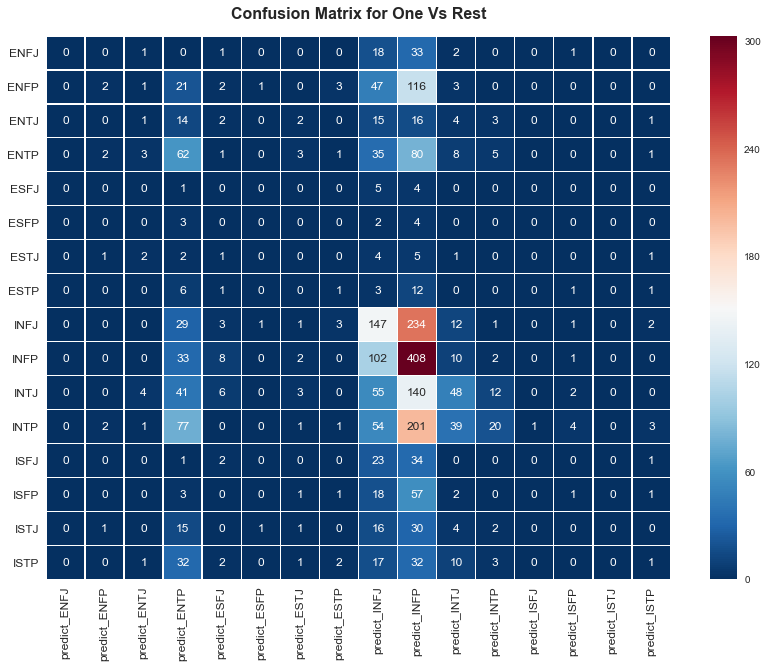

In [13]:
# Create confusion matrix heatmap of One vs. Rest model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for One Vs Rest',
          fontweight='bold', y=1.02, fontsize=16)
sns.heatmap(cm_onevsrest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12);

The heatmapped confusion matrix above shows that, like the other two models, the OneVsRest Classifier labels a majority of the cases as INFP or INFJ, the two most abundant classes in the dataset. However, there are predictions to the other classes as well, in particular the ENTP class. Notably, there are a number of false positives for the ENTP class, in which many members of the Introversion/Intuitive classes were misattributed as ENTP.

---

<a id='text-analysis'></a>
### Sentiment Analysis and Word Count

In [9]:
# View working dataframe head
df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging


In [14]:
# create new column with revised posts text
df_working['posts_r'] = df_working['posts'].copy()

# replaces post separators with empty space
df_working['posts_r'] = df_working['posts'].apply(lambda x: x.replace('|||', ' '))

# replace hyperlinks with 'URL'
df_working['posts_r'] = df_working['posts'].apply(lambda x: re.sub\
                                                  (r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', x, flags=re.MULTILINE))

df_working.head()

,type,posts,I-E,N-S,T-F,J-P,posts_r
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging,'URL and intj moments URL sportscenter not t...
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving,"'Good one _____ URL course, to which I say ..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging,'You're fired.|||That's another silly misconce...


<a id='length-of-post'></a>
#### Length of Post

In [15]:
# Add columns for the total number of words (across 50 posts), and average words per post
df_working['total_words'] = df_working['posts_r'].apply(lambda x: len(re.findall(r'\w+', x)))
df_working['avg_words_per_post'] = df_working['total_words'] / 50
df_working.head()

,type,posts,I-E,N-S,T-F,J-P,posts_r,total_words,avg_words_per_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging,'URL and intj moments URL sportscenter not t...,608,12.16
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving,'I'm finding the lack of me in these posts ver...,1263,25.26
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving,"'Good one _____ URL course, to which I say ...",908,18.16
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging,"'Dear INTP, I enjoyed our conversation the o...",1162,23.24
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging,'You're fired.|||That's another silly misconce...,1043,20.86


In [16]:
# Average length of post overall
df_working['avg_words_per_post'].mean()

26.383808645533186

Overall, the average post length is 26.4 words.

In [17]:
# Average length of post, by 16 types
df_working['avg_words_per_post'].groupby(df_working['type']).mean()

type
ENFJ    27.615895
ENFP    27.089067
ENTJ    26.180433
ENTP    26.014190
ESFJ    27.753333
ESFP    22.156250
ESTJ    26.388718
ESTP    25.037079
INFJ    27.454381
INFP    26.753384
INTJ    25.682420
INTP    25.817132
ISFJ    26.746024
ISFP    24.550996
ISTJ    26.141561
ISTP    25.181068
Name: avg_words_per_post, dtype: float64

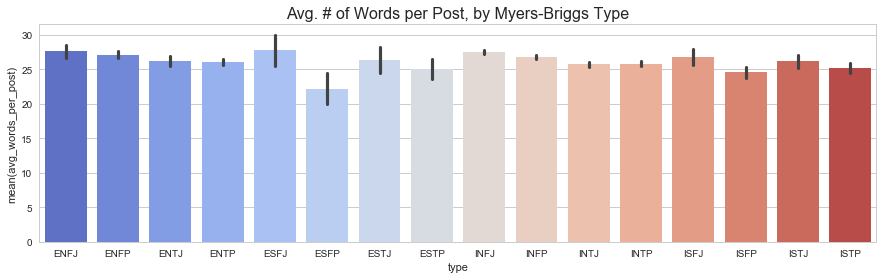

In [46]:
# Bar graph of length of post, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="avg_words_per_post", data=df_working, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"]);
plt.title("Avg. # of Words per Post, by Myers-Briggs Type", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows the average number of words per post does not vary widely across the personality types. (the Extrovert-Sensing types: ESFJ, ESFP, ESTJ, and ESTP have low base sizes and are subject to outlier values). 

In [18]:
# Average length of post, by Introversion (I) – Extroversion (E) axis
df_working['avg_words_per_post'].groupby(df_working['I-E']).mean()

I-E
Extroversion    26.456298
Introversion    26.362103
Name: avg_words_per_post, dtype: float64

In [68]:
# Calculation of standard deviation
df_working['avg_words_per_post'].groupby(df_working['I-E']).std()

I-E
Extroversion    6.327898
Introversion    6.616431
Name: avg_words_per_post, dtype: float64

A **p-value** of **0.05** will be used to determine the significance of t-test results.

In [69]:
# T-test on Introversion - Extroversion axis for average # words per post
stats.ttest_ind_from_stats(mean1=26.456298, std1=6.327898, nobs1=1999, 
                           mean2=26.362103, std2=6.616431, nobs2=6676)

Ttest_indResult(statistic=0.56395469676227539, pvalue=0.57279954601325822)

The p-value of 0.573 is greater than 0.05, thus the difference is not significant.

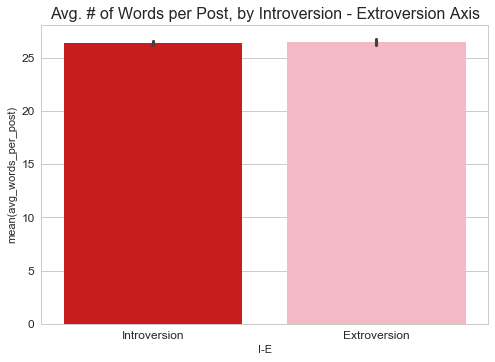

In [30]:
# Bar graph of length of post, by Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.barplot(x="I-E", y="avg_words_per_post", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Avg. # of Words per Post, by Introversion - Extroversion Axis", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows virtually no difference between Introverts and Extroverts in terms of the average number of words per post.

In [16]:
# Average length of post, by Intuition (N) – Sensing (S) axis
df_working['avg_words_per_post'].groupby(df_working['N-S']).mean()

N-S
Intuition    26.538478
Sensing      25.417544
Name: avg_words_per_post, dtype: float64

In [66]:
# Calculation of standard deviations
df_working['avg_words_per_post'].groupby(df_working['N-S']).std()

N-S
Intuition    6.435011
Sensing      7.160158
Name: avg_words_per_post, dtype: float64

In [67]:
# T-test on Intuition - Sensing axis for average # words per post
stats.ttest_ind_from_stats(mean1=26.538478, std1=6.435011, nobs1=7478, 
                           mean2=25.417544, std2=7.160158, nobs2=1197)

Ttest_indResult(statistic=5.5058115482901897, pvalue=3.7796225362733977e-08)

The p-value of 3.78e-08 is lower than 0.05, thus the difference is significant.

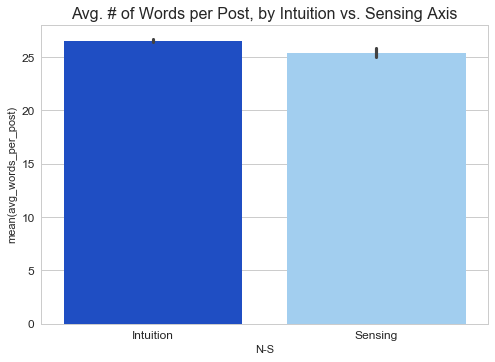

In [31]:
# Bar graph of length of post, by Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.barplot(x="N-S", y="avg_words_per_post", data=df_working, order=["Intuition", "Sensing"])
plt.title("Avg. # of Words per Post, by Intuition vs. Sensing Axis", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above and the t-test prior to that shows that subjects exhibiting higher Intuition traits tend to include more words per post than their Sensing counterparts.

In [17]:
# Average length of post, by Thinking (T) – Feeling (F) axis
df_working['avg_words_per_post'].groupby(df_working['T-F']).mean()

T-F
Feeling     26.890622
Thinking    25.786225
Name: avg_words_per_post, dtype: float64

In [70]:
# Calculate standard deviation
df_working['avg_words_per_post'].groupby(df_working['T-F']).std()

T-F
Feeling     6.582796
Thinking    6.462894
Name: avg_words_per_post, dtype: float64

In [71]:
# T-test on Thinking-Feeling axis for average # words per post
stats.ttest_ind_from_stats(mean1=26.890622, std1=6.582796, nobs1=4694, 
                           mean2=25.786225, std2=6.462894, nobs2=3981)

Ttest_indResult(statistic=7.8519014258342787, pvalue=4.5859900409214915e-15)

The p-value of 4.59e-15 is lower than 0.05, thus the difference is significant.

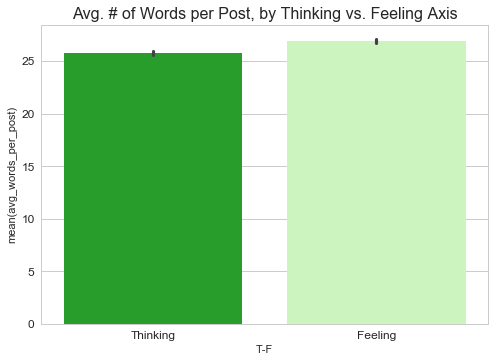

In [32]:
# Bar graph of length of post, by Thinking vs. Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.barplot(x="T-F", y="avg_words_per_post", data=df_working, order=["Thinking", "Feeling"])
plt.title("Avg. # of Words per Post, by Thinking vs. Feeling Axis", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show that subjects with the Feeling trait tend to use significantly more words per post than their Thinking counterparts.

In [18]:
# Average length of post, by Judging (J) – Perceiving (P) axis
df_working['avg_words_per_post'].groupby(df_working['J-P']).mean()

J-P
Judging       26.693599
Perceiving    26.180828
Name: avg_words_per_post, dtype: float64

In [72]:
df_working['avg_words_per_post'].groupby(df_working['J-P']).std()

J-P
Judging       6.604627
Perceiving    6.507981
Name: avg_words_per_post, dtype: float64

In [75]:
# T-test on Judging-Perceiving axis for average # words per post
stats.ttest_ind_from_stats(mean1=26.693599, std1=6.604627, nobs1=5241, 
                           mean2=26.180828, std2=6.507981, nobs2=3434)

Ttest_indResult(statistic=3.5567980529272631, pvalue=0.00037740507727990511)

The p-value of 0.000377 is lower than 0.05, thus the difference is significant.

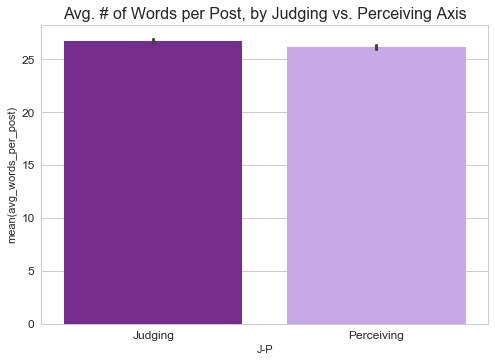

In [33]:
# Bar graph of length of post, by Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.barplot(x="J-P", y="avg_words_per_post", data=df_working, order=["Judging", "Perceiving"])
plt.title("Avg. # of Words per Post, by Judging vs. Perceiving Axis", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show that subjects with the Judging trait tend to use significantly more words per post than their Perceiving counterparts.

<a id='polarity'></a>
#### Polarity

polarity (-1 to 1): scores closer to -1 are more negative in tone, closer to 0 are more neutral, and closer to 1 are more positive in tone.

In [34]:
def polarity(text):
    text = TextBlob(text)
    return text.sentiment.polarity

In [35]:
df_working['polarity'] = df_working['posts_r'].apply(polarity)
df_working.head()

,type,posts,I-E,N-S,T-F,J-P,posts_r,total_words,avg_words_per_post,polarity
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging,'URL and intj moments URL sportscenter not t...,608,12.16,0.145127
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving,'I'm finding the lack of me in these posts ver...,1263,25.26,0.163282
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving,"'Good one _____ URL course, to which I say ...",908,18.16,0.174137
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging,"'Dear INTP, I enjoyed our conversation the o...",1162,23.24,0.114959
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging,'You're fired.|||That's another silly misconce...,1043,20.86,0.056805


In [26]:
# Average polarity of posts, overall
df_working['polarity'].mean()

0.12514124976496832

In [36]:
# Average polarity of posts, by 16 types
df_working['polarity'].groupby(df_working['type']).mean()

type
ENFJ    0.159242
ENFP    0.150337
ENTJ    0.124221
ENTP    0.120692
ESFJ    0.143700
ESFP    0.117940
ESTJ    0.120155
ESTP    0.120773
INFJ    0.133165
INFP    0.129265
INTJ    0.112047
INTP    0.105909
ISFJ    0.135647
ISFP    0.142539
ISTJ    0.119585
ISTP    0.109173
Name: polarity, dtype: float64

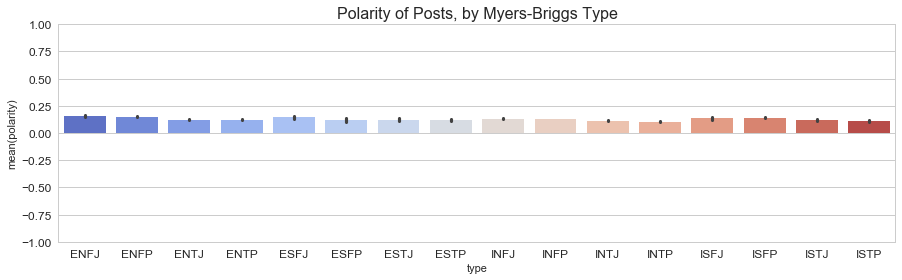

In [37]:
# Bar graph of polarity, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="polarity", data=df_working, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Polarity of Posts, by Myers-Briggs Type", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [28]:
# Average polarity of posts, by Introversion (I) – Extroversion (E) axis
df_working['polarity'].groupby(df_working['I-E']).mean()

I-E
Extroversion    0.135184
Introversion    0.122134
Name: polarity, dtype: float64

In [76]:
# Calculate standard deviation
df_working['polarity'].groupby(df_working['I-E']).std()

I-E
Extroversion    0.060394
Introversion    0.060099
Name: polarity, dtype: float64

In [80]:
# T-test on Introversion - Extroversion axis for polarity
stats.ttest_ind_from_stats(mean1=0.135184, std1=0.060394, nobs1=1999, 
                           mean2=0.122134, std2=0.060099, nobs2=6676)

Ttest_indResult(statistic=8.5070961724423508, pvalue=2.0809156083855346e-17)

The p-value is lower than 0.05, thus the difference is significant.

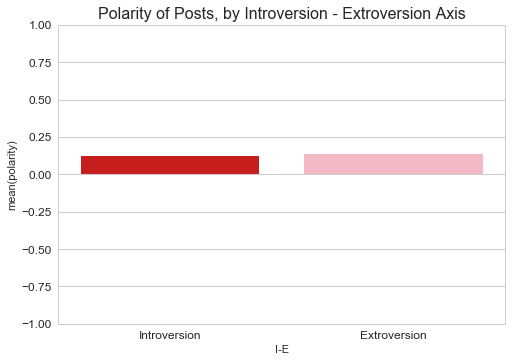

In [38]:
# Bar graph of polarity of posts, by Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.barplot(x="I-E", y="polarity", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Polarity of Posts, by Introversion - Extroversion Axis", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show that Extroverts have a significantly higher positive polarity in tone compared to Introverts, but for both groups the tone is relatively neutral.

In [39]:
# Average polarity of posts, by Intuition (N) – Sensing (S) axis
df_working['polarity'].groupby(df_working['N-S']).mean()

N-S
Intuition    0.125169
Sensing      0.124965
Name: polarity, dtype: float64

In [77]:
# Calculate standard deviation
df_working['polarity'].groupby(df_working['N-S']).std()

N-S
Intuition    0.058632
Sensing      0.070561
Name: polarity, dtype: float64

In [81]:
# T-test on Intuition - Sensing axis for polarity
stats.ttest_ind_from_stats(mean1=0.125169, std1=0.058632, nobs1=7478, 
                           mean2=0.124965, std2=0.070561, nobs2=1197)

Ttest_indResult(statistic=0.10846131975162131, pvalue=0.91363227084567633)

The p-value is greater than 0.05, thus the difference is not significant.

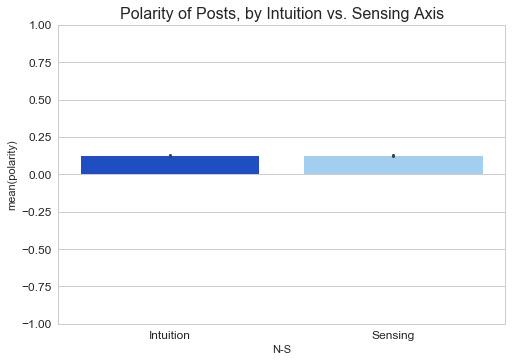

In [40]:
# Bar graph of polarity of posts, by Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.barplot(x="N-S", y="polarity", data=df_working, order=["Intuition", "Sensing"])
plt.title("Polarity of Posts, by Intuition vs. Sensing Axis", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show no significant difference in polarity between subjects higher in Intuition vs. Sensing, and for both groups the tone is relatively neutral.

In [41]:
# Average polarity of posts, by Thinking (T) – Feeling (F) axis
df_working['polarity'].groupby(df_working['T-F']).mean()

T-F
Feeling     0.135736
Thinking    0.112649
Name: polarity, dtype: float64

In [78]:
# Calculate standard deviation
df_working['polarity'].groupby(df_working['T-F']).std()

T-F
Feeling     0.061302
Thinking    0.056876
Name: polarity, dtype: float64

In [82]:
# T-test on Thinking-Feeling axis for polarity
stats.ttest_ind_from_stats(mean1=0.135736, std1=0.061302, nobs1=4694, 
                           mean2=0.112649, std2=0.056876, nobs2=3981)

Ttest_indResult(statistic=18.065841611756031, pvalue=1.2060525809690623e-71)

The p-value is less than 0.05, thus the difference is significant.

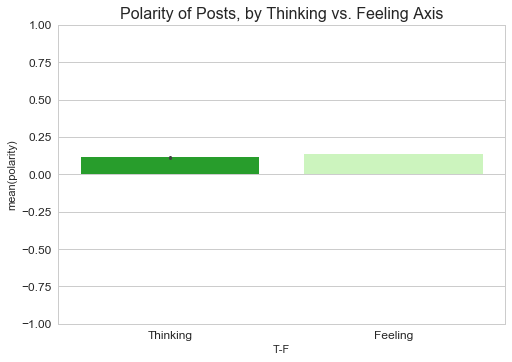

In [42]:
# Bar graph of polarity of posts, by Thinking vs. Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.barplot(x="T-F", y="polarity", data=df_working, order=["Thinking", "Feeling"])
plt.title("Polarity of Posts, by Thinking vs. Feeling Axis", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show that subjects on the Feeling side of the axis have a significantly higher positive polarity in tone compared to those on the Thinking side, but for both groups the tone is relatively neutral.

In [43]:
# Average polarity of posts, by Judging (J) – Perceiving (P) axis
df_working['polarity'].groupby(df_working['J-P']).mean()

J-P
Judging       0.126587
Perceiving    0.124194
Name: polarity, dtype: float64

In [79]:
# Calculate standard deviation
df_working['polarity'].groupby(df_working['J-P']).std()

J-P
Judging       0.060256
Perceiving    0.060504
Name: polarity, dtype: float64

In [83]:
# T-test on Judging-Perceiving axis for polarity
stats.ttest_ind_from_stats(mean1=0.126587, std1=0.060256, nobs1=5241, 
                           mean2=0.124194, std2=0.060504, nobs2=3434)

Ttest_indResult(statistic=1.8059555647452703, pvalue=0.070959935414583591)

The p-value is larger than 0.05, thus the difference is not significant.

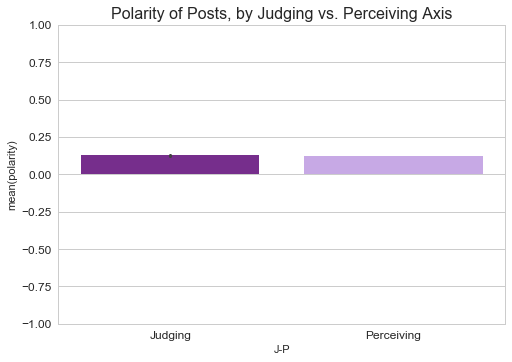

In [44]:
# Bar graph of polarity of posts, by Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.barplot(x="J-P", y="polarity", data=df_working, order=["Judging", "Perceiving"])
plt.title("Polarity of Posts, by Judging vs. Perceiving Axis", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph above and corresponding t-test show no significant differences in terms of polarity for Judgers or Perceivers.

<a id='subjectivity'></a>
#### Subjectivity

subjectivity (0 to 1): scores closer to 0 are more objective in tone, scores closer to 1 are more subjective in tone

In [45]:
def subjectivity(text):
    text = TextBlob(text)
    return text.sentiment.subjectivity

In [46]:
df_working['subjectivity'] = df_working['posts_r'].apply(subjectivity)
df_working.head()

,type,posts,I-E,N-S,T-F,J-P,posts_r,total_words,avg_words_per_post,polarity,subjectivity
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging,'URL and intj moments URL sportscenter not t...,608,12.16,0.145127,0.469713
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving,'I'm finding the lack of me in these posts ver...,1263,25.26,0.163282,0.545346
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving,"'Good one _____ URL course, to which I say ...",908,18.16,0.174137,0.618252
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging,"'Dear INTP, I enjoyed our conversation the o...",1162,23.24,0.114959,0.524975
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging,'You're fired.|||That's another silly misconce...,1043,20.86,0.056805,0.526430


In [47]:
# Average subjectivity of posts, overall
df_working['subjectivity'].mean()

0.5350261671156729

In [48]:
# Average subjectivity of posts, by 16 types
df_working['subjectivity'].groupby(df_working['type']).mean()

type
ENFJ    0.550689
ENFP    0.553359
ENTJ    0.531874
ENTP    0.535292
ESFJ    0.540216
ESFP    0.545247
ESTJ    0.526994
ESTP    0.533286
INFJ    0.536921
INFP    0.541401
INTJ    0.524498
INTP    0.523982
ISFJ    0.546143
ISFP    0.542608
ISTJ    0.518897
ISTP    0.522522
Name: subjectivity, dtype: float64

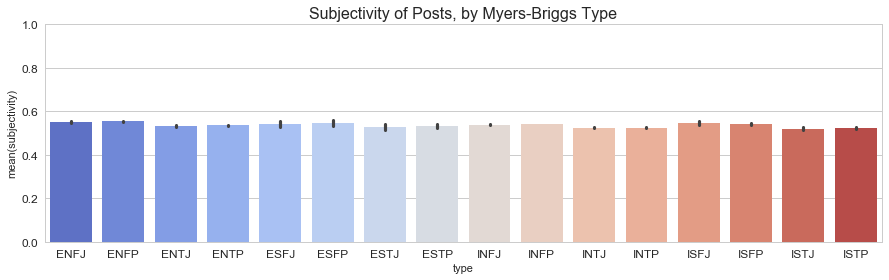

In [49]:
# Bar graph of subjectivity, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="subjectivity", data=df_working, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Subjectivity of Posts, by Myers-Briggs Type", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [50]:
# Average subjectivity of posts, by Introversion (I) – Extroversion (E) axis
df_working['subjectivity'].groupby(df_working['I-E']).mean()

I-E
Extroversion    0.542552
Introversion    0.532773
Name: subjectivity, dtype: float64

In [84]:
# Calculate standard deviation
df_working['subjectivity'].groupby(df_working['I-E']).std()

I-E
Extroversion    0.044716
Introversion    0.045620
Name: subjectivity, dtype: float64

In [88]:
# T-test on Introversion - Extroversion axis for subjectivity
stats.ttest_ind_from_stats(mean1=0.542552, std1=0.044716, nobs1=1999, 
                           mean2=0.532773, std2=0.045620, nobs2=6676)

Ttest_indResult(statistic=8.445800423762277, pvalue=3.5081633540844689e-17)

The p-value is lower than 0.05, thus the difference is significant.

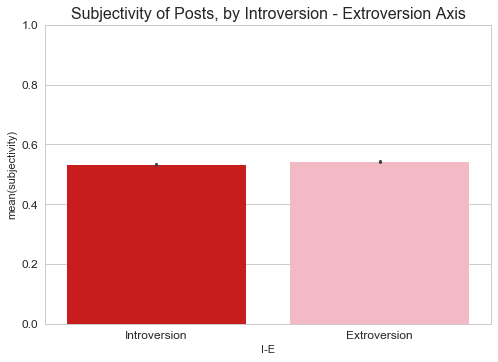

In [51]:
# Bar graph of subjectivity of posts, by Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.barplot(x="I-E", y="subjectivity", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Subjectivity of Posts, by Introversion - Extroversion Axis", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph and associated t-test show that the posts of Introverts have a significantly higher subjectivity than those of Extroverts, but both groups are relatively moderate.

In [52]:
# Average subjectivity of posts, by Intuition (N) – Sensing (S) axis
df_working['subjectivity'].groupby(df_working['N-S']).mean()

N-S
Intuition    0.535478
Sensing      0.532202
Name: subjectivity, dtype: float64

In [85]:
# Calculate standard deviation
df_working['subjectivity'].groupby(df_working['N-S']).std()

N-S
Intuition    0.04455
Sensing      0.05159
Name: subjectivity, dtype: float64

In [89]:
# T-test on Intuition - Sensing axis for subjectivity
stats.ttest_ind_from_stats(mean1=0.535478, std1=0.04455, nobs1=7478, 
                           mean2=0.532202, std2=0.05159, nobs2=1197)

Ttest_indResult(statistic=2.3084602445672062, pvalue=0.020996954292557331)

The p-value is lower than 0.05, thus the difference is significant.

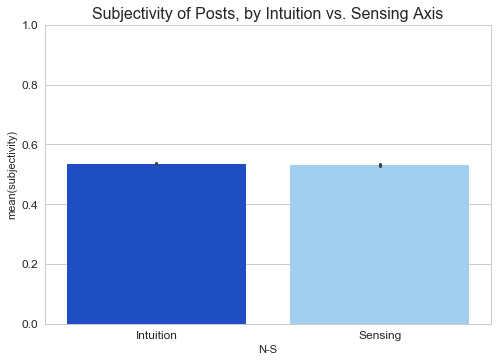

In [53]:
# Bar graph of subjectivity of posts, by Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.barplot(x="N-S", y="subjectivity", data=df_working, order=["Intuition", "Sensing"])
plt.title("Subjectivity of Posts, by Intuition vs. Sensing Axis", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph and corresponding t-test show that subjects classified at the Intuition end of the axis are not significantly different from their Sensing counterparts in terms of subjectivity of their posts. Overall, both groups are fairly moderate in their subjectivity.

In [54]:
# Average subjectivity of posts, by Thinking (T) – Feeling (F) axis
df_working['subjectivity'].groupby(df_working['T-F']).mean()

T-F
Feeling     0.542360
Thinking    0.526379
Name: subjectivity, dtype: float64

In [86]:
# Calculate standard deviation
df_working['subjectivity'].groupby(df_working['T-F']).std()

T-F
Feeling     0.045917
Thinking    0.043668
Name: subjectivity, dtype: float64

In [91]:
# T-test on Thinking-Feeling axis for subjectivity
stats.ttest_ind_from_stats(mean1=0.532694, std1=0.045282, nobs1=4694, 
                           mean2=0.536555, std2=0.045742, nobs2=3981)

Ttest_indResult(statistic=-3.9389613943525532, pvalue=8.2476370045141286e-05)

The p-value is lower than 0.05, thus the difference is significant.

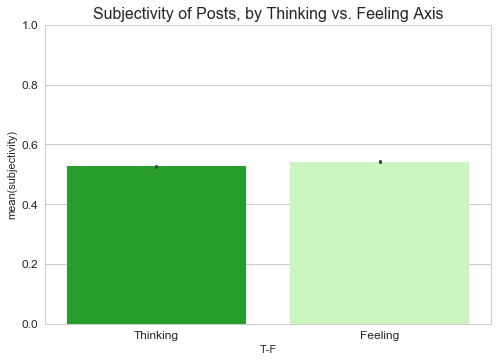

In [55]:
# Bar graph of subjectivity of posts, by Thinking vs. Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.barplot(x="T-F", y="subjectivity", data=df_working, order=["Thinking", "Feeling"])
plt.title("Subjectivity of Posts, by Thinking vs. Feeling Axis", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph and corresponding t-test show that subjects at the Feeling end of the axis have a significantly higher subjectivity to their posts than their Thinking counterparts, but both groups are fairly moderate.

In [56]:
# Average subjectivity of posts, by Judging (J) – Perceiving (P) axis
df_working['subjectivity'].groupby(df_working['J-P']).mean()

J-P
Judging       0.532694
Perceiving    0.536555
Name: subjectivity, dtype: float64

In [92]:
# Calculate standard deviation
df_working['subjectivity'].groupby(df_working['J-P']).std()

J-P
Judging       0.045282
Perceiving    0.045742
Name: subjectivity, dtype: float64

In [93]:
# T-test on Judging-Perceiving axis for subjectivity
stats.ttest_ind_from_stats(mean1=0.532694, std1=0.045282, nobs1=5241, 
                           mean2=0.536555, std2=0.045742, nobs2=3434)

Ttest_indResult(statistic=-3.8681077352664333, pvalue=0.00011048560170015395)

The p-value is lower than 0.05, thus the difference is significant.

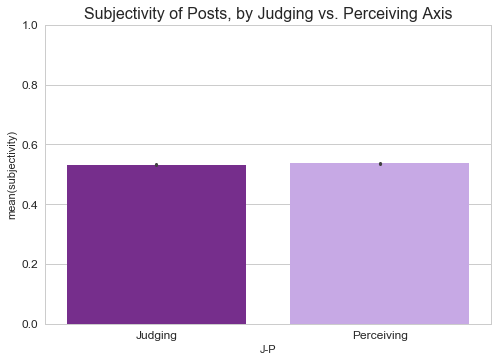

In [57]:
# Bar graph of subjectivity of posts, by Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.barplot(x="J-P", y="subjectivity", data=df_working, order=["Judging", "Perceiving"])
plt.title("Subjectivity of Posts, by Judging vs. Perceiving Axis", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar graph and corresponding t-test show that those at the Perceiving end of the spectrum show significantly higher subjectivity to their posts than their Judging counterparts, yet both groups are relatively moderate.

---

<a id='conclusion'></a>
### Conclusion

While all three models surpassed the baseline of 0.211 in predicting the sixteen classes, they did not all perform similarly. While the *Random Forest Classifier* had the highest accuracy at 0.270, its predictions were limited entirely to the four Introvert-Intuition (IN-) classes, the most abundant classes in the dataset. The *K-Neighbors Classifier* had a much lower accuracy at 0.217, just barely clearing the baseline, but unlike the prior model it posted predictions across the full set of classes. The third model attempted, *One-Vs-The-Rest Classifier*, at 0.265 did not have as high an accuracy score as Random Forest, but it did make predictions across the full range of classes.

At first glance, the *One-Vs-The-Rest Classifier* appears to have a large amount of mismatches in the confusion matrix. However, it is notable that many of the predictions differ from the actual class by only one letter of the type code. Recall that the Myers-Briggs personality types are comprised of four axes which make up the four-letter code. In many cases, if not predicting exactly, the model is able to attribute codes that match on three of the four axes. For example, there are several ENTPs in which Introversion/Intuitive classes were misattributed as ENTP.

In terms of the sentiment analysis and word count, subjects across the axes tended to be fairly moderate in the subjectivity and neutral in polarity of their posts. However, there was a significantly higher subjectivity seen at the Introversion, Sensing, Feeling, and Perceiving ends of the respective axes. Likewise, a significantly higher polarity occurred among subjects at the Extrovert and Feeling ends of those axes. Overall the subjects averaged about 26.4 words per post, with those at the Intuition, Feeling, and Judging poles of their axes having a significantly higher average length. 

---

<a id='next-steps'></a>
### Next Steps

An interesting project for further research can be done using different social media sites, to analyze subjects’ writing style in different contexts. The PersonalityCafe forum, while providing excellent information for the dataset including MBTI personality type, can be a bit limited in scope of the conversation that occurs there. It is also possibly a self-selecting sample, perhaps because Introverts may be more drawn to the topic of personality types than their Extroverted counterparts. A site like Facebook would be a rich source for information, both because the topic of discussion is broadened, and because it may draw a wider diversity of personality types due to its ubiquity. While Facebook does not inherently contain the information regarding personality type, this can be obtained by administering surveys incorporating the MBTI assessment to site users who have consented to participate in research.